### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import geopy.distance
import matplotlib.pyplot as plt
from shapely.geometry import Point
import shapely

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold


from scipy import stats
from sklearn import metrics
import folium

import math

from descartes import PolygonPatch
import altair as alt

from pprint import pprint

# for the notebook only (not for JupyterLab) run this command once per session
alt.renderers.enable('notebook')

import warnings
warnings.filterwarnings('ignore')

### Sensors datapath

In [2]:
### Consts
datapath = '../rawdata/sensors/'
filename = datapath + 'nodes.txt'

### Loading external datasets

In [5]:
## loading 311
noiseComplaints = pd.read_pickle('../data/311/311.pkl')

## loading taxi
taxi = pd.read_pickle('../data/taxi/taxi.pkl')

## loading wind speed
windSpeed = pd.read_pickle('../data/weather/wind.pkl')
windSpeed = windSpeed.resample('H').agg({'Spd[Wind]': 'mean'})

## loading precipitation
precipitation = pd.read_pickle('../data/weather/precipitation.pkl')
precipitation = precipitation.resample('H').agg({'Amt[PrecipHourly1]': 'mean'})

## loading bus
# bus = pd.read_pickle('../data/bus/bus.pkl')

### Calculating the largest intersection across datasets

In [6]:
noiseComplaints_start, noiseComplaints_end = noiseComplaints.index[0], noiseComplaints.index[-1]
taxi_start, taxi_end = taxi.index[0], taxi.index[-1]
windSpeed_start, windSpeed_end = windSpeed.index[0], windSpeed.index[-1]
precipitation_start, precipitation_end = precipitation.index[0], precipitation.index[-1]
# bus_start, bus_end = bus.index[0], bus.index[-1]

## Calculating the largest intersection
intersection_start = max(noiseComplaints_start, taxi_start, windSpeed_start, precipitation_start)
intersection_end = min(noiseComplaints_end, taxi_end, windSpeed_end, precipitation_end)

print('311 Range: ', noiseComplaints_start, '----', noiseComplaints_end)
print('Taxi Range: ', taxi_start, '----', taxi_end)
print('Wind Speed Range: ', windSpeed_start,'----', windSpeed_end)
print('Rain Precipitation Range: ', precipitation_start,'----', precipitation_end)
# print('Bus Range: ', bus_start,'----', bus_end)
print('Largest Intersection: ', intersection_start,'----', intersection_end)

311 Range:  2010-01-01 00:03:46 ---- 2019-01-28 02:11:59
Taxi Range:  2017-01-01 00:00:00 ---- 2018-07-01 23:46:41
Wind Speed Range:  2010-01-01 01:00:00 ---- 2018-04-02 00:00:00
Rain Precipitation Range:  2010-01-01 01:00:00 ---- 2018-04-02 00:00:00
Largest Intersection:  2017-01-01 00:00:00 ---- 2018-04-02 00:00:00


### Loading Time Series

In [62]:
# Load sensors
selectedsensors = [ "sonycnode-b827eb0fedda.sonyc",
                    "sonycnode-b827eb42bd4a.sonyc",
                    "sonycnode-b827eb44506f.sonyc",
                    "sonycnode-b827eb73e772.sonyc",
                    "sonycnode-b827eb74a519.sonyc",
                    "sonycnode-b827eb84deb5.sonyc",
                    "sonycnode-b827ebb40450.sonyc"]

f = open(filename)
sensors = {}

for line in f:
    s, lat, lon = line.split(' ')
    if (s in selectedsensors):
        
        print('Collecting for sensor ', s)
        
        # collection sensor metadata
        sensors[s] = {}
        sensors[s]['lat'] = float(lat)
        sensors[s]['lon'] = float(lon)
        
        # calculating the taxi region to which the sensor belongs
        sensors[s]['taxi_region'] = getSensorLocation(sensors[s]['lat'], sensors[s]['lon'])
        
        # loading sensor data
        sensorData = pd.read_pickle(datapath +s+ '.pkl')
        sensorData.sort_index(ascending=True, inplace=True)
        
        # calculating the intersection with the external datasets
        sensorData_start, sensorData_end = sensorData.index[0], sensorData.index[-1]
        dataframe_start, dataframe_end = max(sensorData_start, intersection_start), min(sensorData_end, intersection_end)
        
        if(dataframe_start > dataframe_end):
            print(s, ': ', 'START >> END')
            continue
        
        # creating empty timeseries
        df_timeseries = pd.DataFrame()
        df_timeseries['datetime'] = pd.date_range(dataframe_start, dataframe_end, freq="1h")
        df_timeseries.set_index(['datetime'], inplace = True)
        
        # calculating the average over one hour of SPL
        sensorData['dbas'] = sensorData['sum'] / sensorData['count']
        
        # adding sensor data to the empty dataframe
        df_timeseries['dbas'] = sensorData['dbas'][dataframe_start:dataframe_end]
        
        # adding wind speed to the dataframe
        df_timeseries['wind'] = windSpeed[dataframe_start:dataframe_end]
        
        # adding rain precipitation to the dataframe
        df_timeseries['precipitation'] = precipitation[dataframe_start:dataframe_end]
        
        print('\t -Adding 311 data...')
        # adding 311 data to the empty dataframe
        ############################
        #SPEEDING UP FOR THIS CASE#
        ###########################
        #################################################################
        noiseComplaints_temp = noiseComplaints['2017-12-31':'2018-12-31']
        #################################################################
        noiseComplaints_temp = noiseComplaints_temp[noiseComplaints_temp.apply(lambda row: pointWithinCircle([row['Latitude'], row['Longitude']], [lat, lon, 200]), axis=1)]
        noiseComplaints_temp = noiseComplaints_temp.resample('H').agg({'Descriptor': 'count'})
        noiseComplaints_temp.rename({'Descriptor':'noise'}, inplace=True)
        df_timeseries['noise'] = noiseComplaints_temp[dataframe_start:dataframe_end]
        
        print('\t -Adding taxi data...')
        # adding taxi data to the empty dataframe
        taxi_temp = taxi[taxi['location'] == sensors[s]['taxi_region']]
        taxi_temp = taxi_temp.resample('H').agg({'location': 'count'})
        taxi_temp.rename({'location':'trips'}, inplace=True)
        df_timeseries['taxi'] = taxi_temp[dataframe_start:dataframe_end]
                
        # filling the missing entries with 0
        df_timeseries.fillna(0, inplace=True)
        df_timeseries['dbas'] = df_timeseries['dbas'].astype(int)
        df_timeseries['dbas'] = df_timeseries['dbas']
        
        # adding cos and sin to the dataframe
        df_timeseries['hour'] = df_timeseries.index.hour
        df_timeseries['hour_sin'] = np.sin(df_timeseries['hour'])
        df_timeseries['hour_cos'] = np.cos(df_timeseries['hour'])

        df_timeseries = df_timeseries.reset_index()
        df_timeseries.drop(columns=['datetime'], inplace=True)
        
        # attach the complete dataframe to a given sensor
        sensors[s]['dataframe'] = df_timeseries 

dataframe_start:  2018-01-01 00:00:00
dataframe_end:  2018-04-02 00:00:00
	 -Adding 311 data...
	 -Adding taxi data...
dataframe_start:  2018-01-01 00:00:00
dataframe_end:  2018-04-02 00:00:00
	 -Adding 311 data...
	 -Adding taxi data...
dataframe_start:  2018-01-01 00:00:00
dataframe_end:  2018-04-02 00:00:00
	 -Adding 311 data...
	 -Adding taxi data...


# Building the model (Pairwise approach)

#### Summary of errors

In [ ]:
### dataframe to keep model prospective provenance
summary_of_errors_pairwise = pd.DataFrame(columns=['training_sensor', 'testing_sensor', 'bin_distance', 'accuracy', 'geo_distance', 'training_sensor_region', 'testing_sensor_region'])

#### Default Classifier

In [ ]:
classifier = RandomForestClassifier(n_estimators=500, random_state=42)

#### Training and predicting

In [ ]:
# TODO: Remove sensor sonycnode-b827eb74a519.sonyc from the model

for trainingSensor in sensors:
        
    print('Training sensor: ', trainingSensor)

    X = sensors[trainingSensor]['dataframe'][['noise','taxi', 'wind', 'precipitation', 'hour_sin', 'hour_cos']]
    y = sensors[trainingSensor]['dataframe'][['dbas']]

    estimator, y_test, y_pred = runEstimator(X, y, classifier, 'continuous')

    ## Comparing the trained model with other models
    for testingSensor in sensors:
        
        if(testingSensor != trainingSensor):
            
            print('Testing sensor: ', testingSensor)

            # plotting sensor's position.
                # Red: sensors used to train
                # Blue: sensors used to test
            plotSensorsPosition(
                [(sensors[trainingSensor]['lat'], sensors[trainingSensor]['lon'])],
                [(sensors[testingSensor]['lat'], sensors[testingSensor]['lon'])],
                [])

            # comparing the model with another sensor's data
            testingPredicted, testingActual = runPredictor(estimator, sensors[testingSensor])

            # plotting predicted and testing timeseries in a single chart
            test_predicted_df = plotClassifier(testingPredicted, testingActual, testingSensor)

            # describing error metrics
            accuracy, bin_distance = plotError(test_predicted_df)

            # appeding error information to the dataframe
            summary_of_errors_pairwise = summary_of_errors_pairwise.append(
                {'training_sensor': trainingSensor, 
                 'testing_sensor': testingSensor,
                 'bin_distance': bin_distance,
                 'accuracy': accuracy, 
                 'geo_distance': diatenceBetweenSensors( 
                     Point(sensors[trainingSensor]['lat'], sensors[trainingSensor]['lon']),
                     Point(sensors[testingSensor]['lat'], sensors[testingSensor]['lon'])),
                 
                }, ignore_index=True)                
        
#             # plotting taxi region
# #             printTaxiRegionSize(trainingSensor, testingSensor)

#### Plotting error correlations

In [ ]:
alt.Chart(summary_of_errors_pairwise).mark_point().encode(
    x='training_sensor:N',
    y='testing_sensor:N',
    fill='bin_distance:Q',
    size='geo_distance:Q'
).properties(
    width=600,
    height=600
)

# Building the model (Permutation Approach)

#### Summary of errors

In [11]:
summary_of_errors_permutation = pd.DataFrame(columns=['bin_distance_default', 'accuracy_default',  'bin_distance_tuning', 'accuracy_tuning', 'bin_distance_training', 'accuracy_training'])

#### Default Classifier

In [12]:
### default classifier
classifier = RandomForestClassifier(n_estimators=500, random_state=42)

#### Training and predicting

In [22]:
variable

,noise,taxi,wind,precipitation,hour_sin,hour_cos,dbas
datetime,,,,,,,
2018-01-01 00:00:00,0.0,55,9.30,0.0,0.000000,1.000000,55
2018-01-01 01:00:00,0.0,78,8.00,0.0,0.841471,0.540302,54
2018-01-01 02:00:00,0.0,80,9.30,0.0,0.909297,-0.416147,57
2018-01-01 03:00:00,0.0,52,9.30,0.0,0.141120,-0.989992,57
2018-01-01 04:00:00,0.0,45,8.50,0.0,-0.756802,-0.653644,56
2018-01-01 05:00:00,0.0,25,3.85,0.0,-0.958924,0.283662,56
2018-01-01 06:00:00,0.0,12,8.20,0.0,-0.279415,0.960170,57
2018-01-01 07:00:00,0.0,15,7.20,0.0,0.656987,0.753902,56
2018-01-01 08:00:00,0.0,16,6.20,0.0,0.989358,-0.145500,56


In [18]:
variable = None

Testing Sensor  sonycnode-b827eb0fedda.sonyc :


Accuracy:  0.07368421052631578
Bin Distance:  4.087871853546911


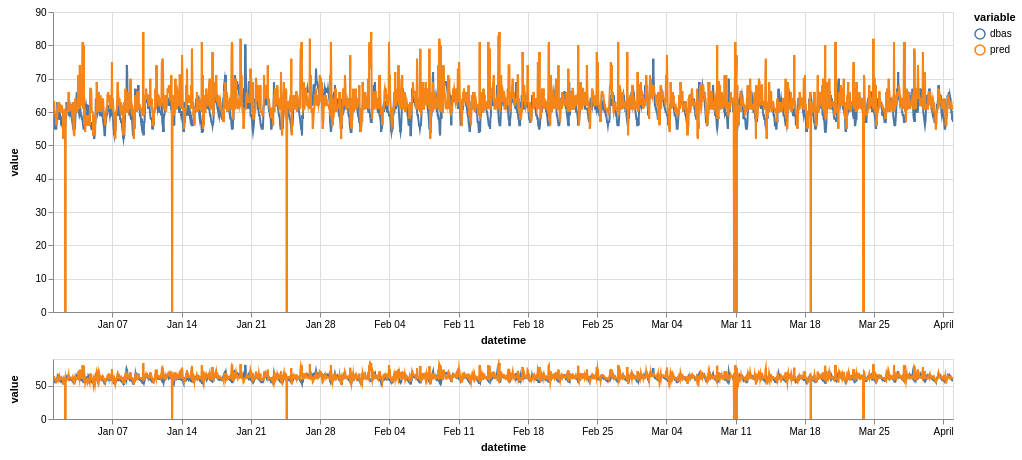

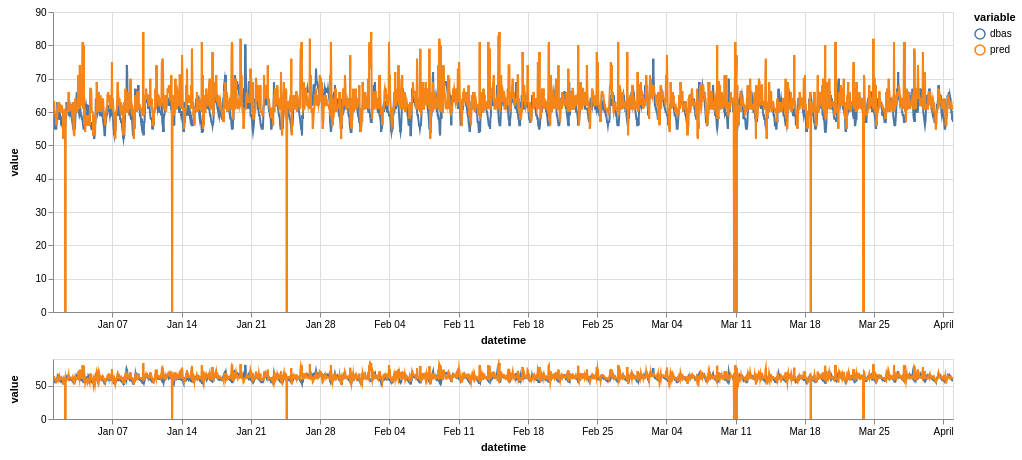

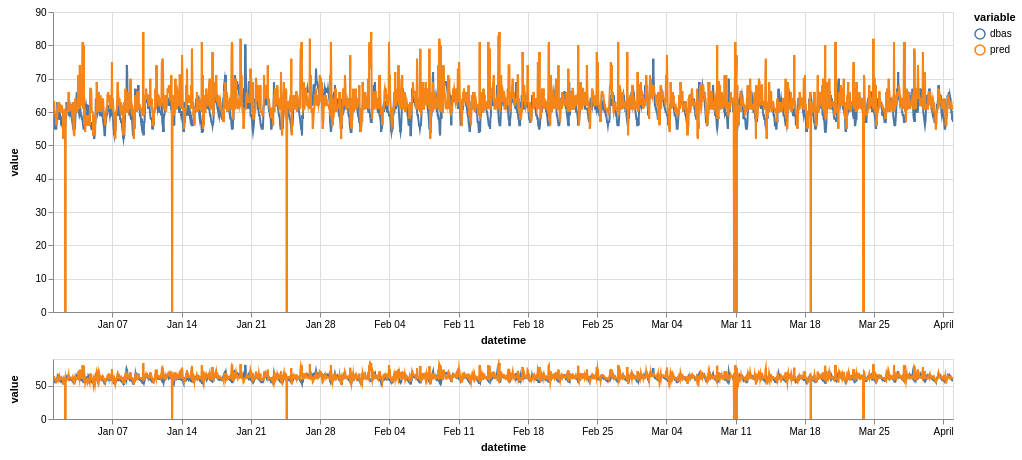

In [21]:
for testingSensor in sensors:
        
    print('Testing Sensor ', testingSensor, ':')

    ## dataframe to append sensors data
    training_df = pd.DataFrame()
    
    ## coordinates of comparing sensors
    training_coords = []
    
    for trainingSensor in sensors:        
        
        if(trainingSensor != testingSensor):
            
            ## storing trainning coords 
            training_coords.append((sensors[trainingSensor]['lat'], sensors[trainingSensor]['lon']))
            
            ## appending sensor data in one dataframe
            training_df = training_df.append(sensors[trainingSensor]['dataframe'])
            
            
    ## plotting sensors' position.
#     plotSensorsPosition(training_coords, [(sensors[testingSensor]['lat'], sensors[testingSensor]['lon'])], [])
    
    ## spliting in X (features) and y (result)
    X_train = training_df[['noise','taxi', 'wind', 'precipitation', 'hour_sin', 'hour_cos']]
    y_train = training_df[['dbas']]
    
    ###### continuous split ######
    
    ## training with data for all the sensors
    estimator, y_test, y_pred = runEstimator(X_train, y_train, classifier, 'continuous')
    
    ## comparing the model with another sensor's data
    testingPredicted, testingActual = runPredictor(estimator, sensors[testingSensor])
    
    ## plotting both timeseries in a single chart
    test_predicted_df = plotClassifier(testingPredicted, testingActual, testingSensor)
        
    ## describing error metrics
    accuracy, bin_distance = plotError(test_predicted_df)
    
    
    variable = training_df[['noise','taxi', 'wind', 'precipitation', 'hour_sin', 'hour_cos', 'dbas']]
    
    break
    
#     ## parameters used by the estimator
#     importanceChart(estimator, X_train)

    #############HYPERPARAMETERS ESTIMATION#############
    
#     ## Choosing best hyperparameters using RandomizedSearchCV
#     best_estimator = bestParameters(X_train, y_train, classifier)
    
#     ## run predictor with best parameters
#     testingPredicted_tuning, testingActual_tuning = runPredictor(best_estimator, sensors[testingSensor])
    
#     ## plotting both timeseries in a single chart
#     test_predicted_df_tuning = plotClassifier(testingPredicted_tuning, testingActual_tuning, testingSensor)
    
#     ## describing error metrics for hyperparameters estimation
#     accuracy_tuning, bin_distance_tuning = plotError(test_predicted_df_tuning)
    
#     #############CROSS VALIDATION#############
    
    
    
    
        
#     summary_of_errors_permutation = summary_of_errors_permutation.append(
#                 {'bin_distance_default': bin_distance,
#                  'accuracy_default': accuracy, 
#                  'bin_distance_tuning': bin_distance_tuning,
#                  'accuracy_tuning': accuracy_tuning,
#                  'bin_distance_training':'TODO',
#                  'accuracy_training':'TODO'
#                 }, ignore_index=True)    

#             # filling in the error matrix with bin_distance
#             errorMatrix_binDistance.loc[sensor][comparingSensor] = float(bin_distance)
#             errorMatrix_accuracy.loc[sensor][comparingSensor] = float(accuracy)
        
#             # plotting taxi region
#             printTaxiRegionSize(sensor, comparingSensor)

#### Improvement

In [ ]:
barChartTuning(summary_of_errors_permutation)

# Building the model (Citizen Simulation)

In [ ]:
summary_of_errors_citizen = pd.DataFrame(columns=['testing_sensors', 'testing_sensors_coords',  'citizen_sensors', 'citizen_sensors_coords', 'training_sensors', 'training_sensors_coords', 'bin_distance_before', 'bin_distance_after'])

In [ ]:
classifier = RandomForestClassifier(n_estimators=500, random_state=42)

In [ ]:
for testingSensor in sensors:
        
    print('Testing sensor ', testingSensor, ':')
    
    for citizenSensor in sensors:
        
        if(citizenSensor == testingSensor):
            continue
        
        ## dataframe that will keep training features
        training_df = pd.DataFrame()
        
        ## coordinates of training sensors
        training_coords = []
        
        ## id of training sensors
        training_ids = []
        
        for trainingSensor in sensors:        
        
            if( (trainingSensor != testingSensor) and (trainingSensor != citizenSensor)):
            
                ## storing trainning coords 
                training_coords.append((sensors[trainingSensor]['lat'], sensors[trainingSensor]['lon']))
                
                ## appending the name of sensors used to train
                training_ids.append(trainingSensor)
            
                ## appending sensor data in one dataframe
                training_df = training_df.append(sensors[trainingSensor]['dataframe'])
        
        ## plotting sensors' position.
        plotSensorsPosition(training_coords, [(sensors[testingSensor]['lat'], sensors[testingSensor]['lon'])], [(sensors[citizenSensor]['lat'], sensors[citizenSensor]['lon'])])
                    
        ########### BEFORE ADDING CITIZEN SENSOR ##########    
        
        ## spliting in X (features) and y (result)
        X = training_df[['noise','taxi', 'wind', 'precipitation', 'hour_sin', 'hour_cos']]
        y = training_df[['dbas']]
    
        ## training with data for all the sensors
        estimator, y_test, y_pred = runEstimator(X, y, classifier, 'continuous')
        
        ## comparing the model with another sensor's data
        testingPredicted, testingActual = runPredictor(estimator, sensors[testingSensor])
        
        ## plotting both timeseries in a single chart
        test_predicted_df = plotClassifier(testingPredicted, testingActual, testingSensor)
        
        ## calculating error for each pair (testing, citizen) before adding the citizen
        accuracy_before, bin_distance_before = plotError(test_predicted_df)
        
        ########### AFTER ADDING CITIZEN SENSOR ##########  
        
        ## adding the citizen sensor
        training_df = training_df.append(sensors[citizenSensor]['dataframe'])
        
        ## spliting in X (features) and y (result)
        X = training_df[['noise','taxi', 'wind', 'precipitation', 'hour_sin', 'hour_cos']]
        y = training_df[['dbas']]
        
        ## training with data for all the sensors
        estimator, y_test, y_pred = runEstimator(X, y, classifier, 'continuous')
        
        ## comparing the model with another sensor's data
        testingPredicted, testingActual = runPredictor(estimator, sensors[testingSensor])
        
        ## plotting both timeseries in a single chart
        test_predicted_df = plotClassifier(testingPredicted, testingActual, testingSensor)
        
        ## calculating error for each pair (testing, citizen) before adding the citizen
        accuracy_after, bin_distance_after = plotError(test_predicted_df)
        
        ## adding to the summary of errors
        summary_of_errors_citizen = summary_of_errors_citizen.append(
                {'testing_sensors': [testingSensor], 
                 'testing_sensors_coords': [(sensors[testingSensor]['lat'], sensors[testingSensor]['lon'])],
                 'citizen_sensors': [citizenSensor],
                 'citizen_sensors_coords': [(sensors[citizenSensor]['lat'], sensors[citizenSensor]['lon'])],
                 'training_sensors': training_ids,
                 'training_sensors_coords': training_coords,
                 'bin_distance_before': bin_distance_before,
                 'bin_distance_after': bin_distance_after,
                 'accuracy_before': accuracy_before,
                 'accuracy_after': accuracy_after,
                 'geo_distance': diatenceBetweenSensors( 
                     Point(sensors[testingSensor]['lat'], sensors[testingSensor]['lon']),
                     Point(sensors[citizenSensor]['lat'], sensors[citizenSensor]['lon'])),
                }, ignore_index=True)  

In [ ]:
## adding bin_distance difference
summary_of_errors_citizen['bin_distance_diff'] = summary_of_errors_citizen['bin_distance_before'] - summary_of_errors_citizen['bin_distance_after']
summary_of_errors_citizen.sort_values(by=['geo_distance'], ascending=True, inplace=True)

In [ ]:
plotBarChart(summary_of_errors_citizen)

In [ ]:
tupleNumber = 21

trainingSensors = summary_of_errors_citizen.loc[tupleNumber]['training_sensors_coords']
testingSensors = summary_of_errors_citizen.loc[tupleNumber]['testing_sensors_coords']
citizenSensors = summary_of_errors_citizen.loc[tupleNumber]['citizen_sensors_coords']
metric = summary_of_errors_citizen.loc[tupleNumber]['bin_distance_diff']
plotSensorsPosition(trainingSensors, testingSensors, citizenSensors, tooltip=metric)

# Helper Functions

### Geospatial functions

In [9]:
# loading taxi regions
taxi_regions = gpd.read_file('zip://../assets/taxi_zones.zip')

# translating polygon to lat/lng
crs = {'init': 'epsg:4326'}
taxi_regions = taxi_regions.to_crs(crs)

def getSensorLocation(lat, lng):
    ## TODO: Refactor function return
    ## get neighboorhood ID of a coordinate
    point = Point(lng, lat)
    taxi_regions['intersect'] = taxi_regions.apply(lambda row: row['geometry'].intersects(point), axis=1)
    region =  taxi_regions[taxi_regions['intersect'] == True]['LocationID']
    return region.values[0]

## Default radius
radius = 200
def pointWithinCircle(point, circle):
    ## Return if a given point is within a circle
    c = (circle[0], circle[1])
    r = circle[2]
    dist = geopy.distance.distance(c, point).meters
    if dist <= r:
        return True

    return False

def diatenceBetweenSensors(sensor1, sensor2):
    return sensor1.distance(sensor2)

### Processing functions

In [8]:
def runPredictor(estimator, sensor):
    
    Xlocal = sensor['dataframe'][['noise', 'taxi', 'wind', 'precipitation', 'hour_sin', 'hour_cos']]
    ylocal = sensor['dataframe'][['dbas']]
    
    yPredLocal = estimator.predict(Xlocal)
    
    return yPredLocal, ylocal

def runEstimator(X, y, estimator, randomize):

    if(randomize == 'random'):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)
        
    elif(randomize == 'continuous'):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)
        
    return estimator, y_test, y_pred
    
def plotError(dataframe):
    
    accuracy = metrics.accuracy_score(dataframe['dbas'], dataframe['pred'])
    bin_distance = metrics.mean_absolute_error(dataframe['dbas'],  dataframe['pred'])
    
    print('Accuracy: ', accuracy)
    print('Bin Distance: ', bin_distance)
    
    return accuracy, bin_distance

def printTaxiRegionSize(sensor, comparingSensor):
    print(taxi_regions[taxi_regions['LocationID'] == sensors[sensor]['taxi_region']]['Shape_Area'])
    print(taxi_regions[taxi_regions['LocationID'] == sensors[comparingSensor]['taxi_region']]['Shape_Area'])    
    
    
def parameter_grid():
    
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    
    hyperparameter_grid = {'n_estimators': n_estimators,
                           'max_features': max_features,
                           'max_depth': max_depth,
                           'min_samples_split': min_samples_split,
                           'min_samples_leaf': min_samples_leaf,
                           'bootstrap': bootstrap}
    
    return hyperparameter_grid

def bestParameters(X_train, y_train, classifier):

    # get grid of hyperparameters
    random_grid = parameter_grid()
    
    # declaring the random search estimator
    rf_random = RandomizedSearchCV(estimator = classifier, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=0, random_state=42, n_jobs = -1)
    
    # fit the random search model
    rf_random.fit(X_train, y_train)
    
    return rf_random

def spatialJoin(geoDataframe, lat, lon):
    d = 200 # meters
    n_points = 20
    angles = np.linspace(0, 360, n_points)
    center = shapely.geometry.Point(lon,lat)
    polygon = geog.propagate(p, angles, d)
    dataframe = gpd.tools.sjoin(geoDataframe,polygon,op="within")
    return dataframe

### Visualization Functions

In [7]:
def plotSensorsPosition(trainingSensors, testingSensors, citizenSensors, tooltip='NO DATA'):
    
    map_osm = folium.Map(location=[40.742, -73.956], zoom_start=12, tiles="cartodbpositron")
    
    for lat, lng in trainingSensors:
        folium.CircleMarker(
            location=[lat, lng],
            radius=5,
            fill=True,
            fill_opacity=0.5,
            fill_color="red",
            color="black").add_to(map_osm)
    
    for lat, lng in testingSensors:
        folium.CircleMarker(
            location=[lat, lng],
            radius=5,
            fill=True,
            fill_opacity=0.5,
            fill_color="blue",
            color="black").add_to(map_osm)
        
    for lat, lng in citizenSensors:
        folium.CircleMarker(
            location=[lat, lng],
            radius=5,
            fill=True,
            fill_opacity=0.5,
            fill_color="yellow",
            tooltip=tooltip,
            color="black").add_to(map_osm) 
        
        
    display(map_osm)
    
def plotClassifier(y_pred, y_test, title):

    # attaching predicted values
    y_test['pred'] = y_pred

    # tranforming to long form
    long_form_df = pd.melt(y_test.reset_index(), id_vars=['datetime'])
    
    brush = alt.selection(type='interval', encodings=['x'])

    upper = alt.Chart(long_form_df).mark_line().encode(
        alt.X('datetime', type='temporal', scale={'domain': brush.ref()}),
        alt.Y('value', type='quantitative', scale=alt.Scale(zero=False)),
        color='variable'
    ).properties(
        width=900
    )

    lower = upper.properties(
        height=60
    ).add_selection(brush)

    display(alt.vconcat(upper, lower))
    
    return y_test

def plotBarChart(dataframe):
    
    bar_chart = alt.Chart(dataframe.reset_index()).mark_bar().encode(
        alt.X('index', type='nominal', sort=None),
        alt.Y('bin_distance_diff', type='quantitative'),
        color='geo_distance:Q',
        tooltip=['geo_distance', 'testing_sensors', 'citizen_sensors']
    ).properties(
        width = 850
    )
    
    display(bar_chart)
    
def importanceChart(estimator, train_set):
    
    dataframe = pd.DataFrame(estimator.feature_importances_, index=train_set.columns, columns=['importance'])
    
    bar_chart = alt.Chart(dataframe.reset_index()).mark_bar().encode(
        alt.X('index', type='nominal'),
        alt.Y('importance', type='quantitative')
    ).properties(
        width=500
    )
    
    display(bar_chart)
    
    
def barChartTuning(dataframe):
    
    chart_df = dataframe.drop(columns=['accuracy_default', 'accuracy_tuning', 'bin_distance_training', 'accuracy_training'])
    
    # tranforming to long form
    long_form_df = pd.melt(chart_df.reset_index(), id_vars=['index'])
    
    bar_chart = alt.Chart(long_form_df).mark_bar().encode(
        
        x='variable:N',
        y='value:Q',
        column='index:O',
        color='variable:N'
        
    )
    
    display(bar_chart)